In [1]:
import matplotlib.pyplot as plt
# import dataprep # this not working
import pandas as pd
import numpy as np
    
# # Import the data
# signal_data = pd.read_hdf("/dice/projects/CMS/Hinv/datasets_for_ml_training/ttH/df_ml_inputs.hd5")
# background_data = pd.read_hdf("/dice/projects/CMS/Hinv/datasets_for_ml_training/ttBar/df_ml_inputs.hd5")

signal_data = pd.read_parquet('/cephfs/dice/projects/CMS/Hinv/ml_datasets_ul/UL2018_ml_inputs/ttH_HToInvisible_M125.parquet')
background_data_data = pd.read_parquet('/cephfs/dice/projects/CMS/Hinv/ml_datasets_ul/UL2018_ml_inputs/TTToSemiLeptonic.parquet')


def prep(signal_data, background_data):

    import pandas as pd
    import numpy as np

    # Remove nan values
    signal_data = signal_data.dropna()
    background_data = background_data.dropna()

    # Remove regions 1-5 as they contain data not suitable for training
    # signal_data = signal_data[~signal_data.region.isin([1, 2, 3, 4, 5])]
    # background_data = background_data[~background_data.region.isin([1, 2, 3, 4, 5])]

    signal_data = signal_data[signal_data.region == 0]
    background_data = background_data[background_data.region == 0]


    # Adding in balance weights 

    signal_data['weight_balance'] = len(background_data) / len(signal_data)
    background_data['weight_balance'] = 1

    # Combine data + add feautures
    signal_data['target'] = 1
    background_data['target'] = 0
    data = pd.concat([signal_data, background_data])

    # Creation of additional useful features found from 'investigatingjets.ipynb'
    # cleanedJet_eta_std, cleanedJet_eta_range, cleadJet_phi_std, cleanedJet_phi_range

    data['cleanedJet_eta_std'] = data['cleanedJet_eta'].apply(lambda x: np.std(x))
    data['cleanedJet_eta_range'] = data['cleanedJet_eta'].apply(lambda x: np.max(x) - np.min(x))
    data['cleanedJet_phi_std'] = data['cleanedJet_phi'].apply(lambda x: np.std(x))
    data['cleanedJet_phi_range'] = data['cleanedJet_phi'].apply(lambda x: np.max(x) - np.min(x))

    return data

data = prep(signal_data, background_data)

# List of variables to use for training
features = ['DiJet_mass', 'HT', 'InputMet_InputJet_mindPhi',
       'InputMet_pt', 'MHT_pt', 'MinChi',
       'MinOmegaHat', 'MinOmegaTilde', 'cleanedJet_eta_std', 'cleanedJet_eta_range',
       'cleanedJet_phi_range', 'cleanedJet_phi_std', 'ldphi_bjet',
       'ldphi_jet', 'ncleanedBJet', 'ncleanedJet', 'region', 'sdphi_bjet',
       'sdphi_jet']

weights_copy = data['weight_nominal'].copy() # Use this one for saving the weights when balancing by adding weight_balance

# Use 30% of the data

from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

# Normalise the data

data = train.copy()

### Model and training

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import optuna

# Standardize the features
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Convert data to PyTorch tensors
X = torch.tensor(data[features].values, dtype=torch.float32)
y = torch.tensor(data['target'].values, dtype=torch.float32)  # For BCE loss, use float labels
weights_nominal = torch.tensor(data['weight_nominal'].values, dtype=torch.float32)
weights_balance = torch.tensor(data['weight_balance'].values, dtype=torch.float32)

# Split data into training+validation and test sets (80/20)
X_train_val, X_test, y_train_val, y_test, wn_train_val, wn_test, wb_train_val, wb_test = train_test_split(X, y, weights_nominal, weights_balance, test_size=0.2, random_state=42)

# Further split the training data into train and validation sets (80/20 of 80%)
X_train, X_val, y_train, y_val, wn_train, wn_val, wb_train, wb_val  = train_test_split(X_train_val, y_train_val, wn_train_val, wb_train_val, test_size=0.2, random_state=42)

# Create DataLoaders for each set
train_loader = DataLoader(TensorDataset(X_train, y_train, wn_train, wb_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val, wn_val, wb_val), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test, wn_test, wb_test), batch_size=64, shuffle=False)

# Define the model
n_features = len(features)

def objective(trial):
    # Suggest values for hyperparameters
    n_layers = trial.suggest_int('n_layers', 1, 3)  # Example: 1 to 3 layers
    n_neurons = trial.suggest_int('n_neurons', 16, 128, step=16)  # Neurons per layer
    lr = trial.suggest_categorical('lr', [0.05, 0.01, 0.005, 0.001])

    # Define the model with suggested hyperparameters
    class SimpleNN(nn.Module):
        def __init__(self):
            super(SimpleNN, self).__init__()
            layers = [nn.Linear(n_features, n_neurons), nn.BatchNorm1d(n_neurons)]
            
            for _ in range(n_layers - 1):
                layers.append(nn.Linear(n_neurons, n_neurons))
                layers.append(nn.BatchNorm1d(n_neurons))

            layers.append(nn.Linear(n_neurons, 1))
            self.layers = nn.ModuleList(layers)

        def forward(self, x):
            for layer in self.layers[:-1]:
                x = torch.relu(layer(x))
            x = self.layers[-1](x)
            return x

    model = SimpleNN()

    # Loss and optimizer
    criterion = nn.BCEWithLogitsLoss(reduction="none")
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training parameters
    n_epochs = 10  # Keep epochs low for tuning to save time
    train_losses = []

    # Training loop
    for epoch in range(n_epochs):
        model.train()
        running_train_loss = 0.0
        for batch_x, batch_y, batch_wn, batch_wb in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            batch_y = batch_y.view(-1, 1)
            loss = criterion(outputs, batch_y)
            weighted_loss = (loss * batch_wb).mean()
            weighted_loss.backward()
            optimizer.step()
            running_train_loss += weighted_loss.item() * batch_x.size(0)

        # Calculate average loss per epoch
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

    # Validation phase (to get the final validation loss as the metric)
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y, batch_wn, batch_wb in val_loader:
            outputs = model(batch_x)
            batch_y = batch_y.view(-1, 1)
            val_loss = criterion(outputs, batch_y)
            weighted_val_loss = (val_loss * batch_wb).mean()
            running_val_loss += weighted_val_loss.item() * batch_x.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)

    print(epoch_val_loss)

    return epoch_val_loss  # Optuna will try to minimize this

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=12, n_jobs = 4)  # Try 20 different combinations of hyperparameters

# Print the best parameters
print("Best hyperparameters:", study.best_params)


[I 2024-11-12 10:54:52,410] A new study created in memory with name: no-name-e149c333-aaa0-4292-9cba-f82540f42a47
[I 2024-11-12 10:58:25,971] Trial 3 finished with value: 0.6994899142303871 and parameters: {'n_layers': 1, 'n_neurons': 16, 'lr': 0.003740197770163659}. Best is trial 3 with value: 0.6994899142303871.


0.6994899142303871


[I 2024-11-12 10:58:46,144] Trial 1 finished with value: 0.6944837926655789 and parameters: {'n_layers': 1, 'n_neurons': 48, 'lr': 0.0003277943720259822}. Best is trial 1 with value: 0.6944837926655789.


0.6944837926655789


[I 2024-11-12 11:01:37,742] Trial 0 finished with value: 0.6896014258767584 and parameters: {'n_layers': 3, 'n_neurons': 48, 'lr': 0.0003702837960116371}. Best is trial 0 with value: 0.6896014258767584.


0.6896014258767584


[I 2024-11-12 11:02:09,212] Trial 2 finished with value: 0.6920667622481261 and parameters: {'n_layers': 3, 'n_neurons': 96, 'lr': 0.00020834200552320687}. Best is trial 0 with value: 0.6896014258767584.


0.6920667622481261


[I 2024-11-12 11:04:26,490] Trial 4 finished with value: 0.6881222872142287 and parameters: {'n_layers': 2, 'n_neurons': 80, 'lr': 0.03392254943911601}. Best is trial 4 with value: 0.6881222872142287.


0.6881222872142287


[I 2024-11-12 11:05:12,709] Trial 5 finished with value: 0.6889446935392811 and parameters: {'n_layers': 3, 'n_neurons': 16, 'lr': 0.007302560398985652}. Best is trial 4 with value: 0.6881222872142287.


0.6889446935392811


[I 2024-11-12 11:10:58,395] Trial 8 finished with value: 0.6962254913730724 and parameters: {'n_layers': 1, 'n_neurons': 112, 'lr': 0.0003677650460875217}. Best is trial 4 with value: 0.6881222872142287.


0.6962254913730724


[I 2024-11-12 11:11:32,643] Trial 7 finished with value: 0.6871867711148671 and parameters: {'n_layers': 2, 'n_neurons': 128, 'lr': 0.0019704280928992406}. Best is trial 7 with value: 0.6871867711148671.


0.6871867711148671


[I 2024-11-12 11:12:50,091] Trial 6 finished with value: 0.6869705443579186 and parameters: {'n_layers': 3, 'n_neurons': 32, 'lr': 0.014567215281793241}. Best is trial 6 with value: 0.6869705443579186.


0.6869705443579186


[I 2024-11-12 11:20:15,805] Trial 9 finished with value: 0.6879358446946243 and parameters: {'n_layers': 3, 'n_neurons': 80, 'lr': 0.0013239685661535362}. Best is trial 6 with value: 0.6869705443579186.


0.6879358446946243


[I 2024-11-12 11:21:14,976] Trial 10 finished with value: 0.6883603074269656 and parameters: {'n_layers': 2, 'n_neurons': 112, 'lr': 0.03102460414680501}. Best is trial 6 with value: 0.6869705443579186.


0.6883603074269656


[I 2024-11-12 11:21:22,609] Trial 11 finished with value: 0.6934099245168803 and parameters: {'n_layers': 3, 'n_neurons': 16, 'lr': 0.000463378688503421}. Best is trial 6 with value: 0.6869705443579186.


0.6934099245168803
Best hyperparameters: {'n_layers': 3, 'n_neurons': 32, 'lr': 0.014567215281793241}


### Evalution of model

In [3]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Collect all predictions and true labels
all_outputs = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y, batch_wn, batch_wb in test_loader:
        # Get model outputs (logits if using BCEWithLogitsLoss)
        outputs = model(batch_x)
        
        # Apply sigmoid if necessary to get probabilities
        probs = torch.sigmoid(outputs).numpy()  # Convert to numpy for compatibility
        all_outputs.extend(probs)
        all_labels.extend(batch_y.numpy())

# Convert lists to numpy arrays
all_outputs = np.array(all_outputs).flatten()  # Flatten to a 1D array
print(all_outputs)
all_labels = np.array(all_labels)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_outputs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", label=f"ROC curve (area = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")  # Diagonal line for random performance
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


NameError: name 'model' is not defined

In [6]:
from torchinfo import summary
summary(model, input_size=(32, n_features))  # Replace 64 with your batch size


Layer (type:depth-idx)                   Output Shape              Param #
SimpleNN                                 [32, 1]                   --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [32, 32]                  640
│    └─BatchNorm1d: 2-2                  [32, 32]                  64
│    └─Linear: 2-3                       [32, 32]                  1,056
│    └─BatchNorm1d: 2-4                  [32, 32]                  64
│    └─Linear: 2-5                       [32, 32]                  1,056
│    └─BatchNorm1d: 2-6                  [32, 32]                  64
│    └─Linear: 2-7                       [32, 1]                   33
Total params: 2,977
Trainable params: 2,977
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.10
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.01
Estimated Total Size (MB): 0.06

### Histogram output plots

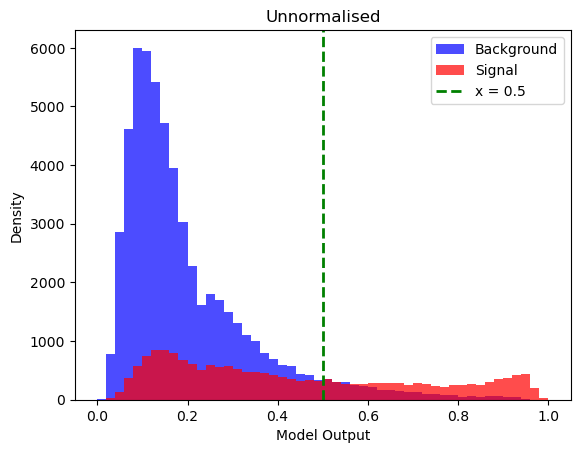

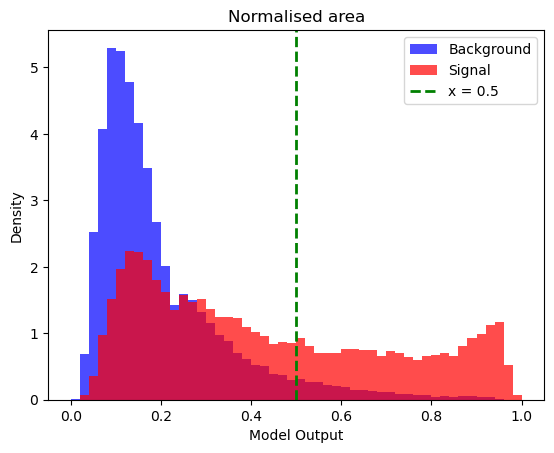

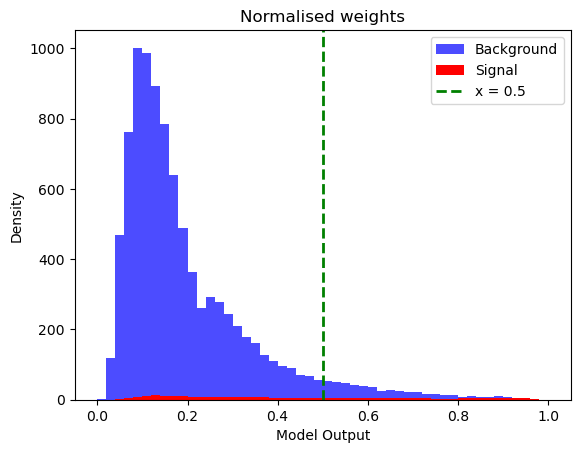

In [7]:
# Plot a hisogram of the model outputs for signal and background
model.eval()

# Collect all predictions and true labels

all_outputs = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y, batch_wn, batch_wb in test_loader:
        # Get model outputs (logits if using BCEWithLogitsLoss)
        outputs = model(batch_x)
        
        # Apply sigmoid if necessary to get probabilities
        probs = torch.sigmoid(outputs).numpy()  # Convert to numpy for compatibility
        all_outputs.extend(probs)
        all_labels.extend(batch_y.numpy())

# Convert lists to numpy arrays

all_outputs = np.array(all_outputs).flatten()  # Flatten to a 1D array
all_labels = np.array(all_labels)

# Plot the model outputs for signal and background

plt.hist(all_outputs[all_labels == 0], bins=50, range=(0, 1),alpha = 0.7, label='Background', color='b')
plt.hist(all_outputs[all_labels == 1], bins=50, range=(0, 1),alpha = 0.7, label='Signal', color='r')
plt.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='x = 0.5')
plt.xlabel('Model Output')
plt.ylabel('Density')
plt.title("Unnormalised")
plt.legend()
plt.show()

plt.hist(all_outputs[all_labels == 0], bins=50, range=(0, 1),alpha = 0.7, label='Background', density='true', color='b')
plt.hist(all_outputs[all_labels == 1], bins=50, range=(0, 1),alpha = 0.7, label='Signal', density='true', color='r')
plt.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='x = 0.5')
plt.xlabel('Model Output')
plt.ylabel('Density')
plt.title("Normalised area")
plt.legend()
plt.show()

plt.hist(all_outputs[all_labels == 0], bins=50, range=(0, 1),alpha = 0.7, label='Background', weights=wn_test[all_labels == 0]*200000, color='b')
plt.hist(all_outputs[all_labels == 1], bins=50, range=(0, 1), label='Signal',  weights=wn_test[all_labels == 1]*200000, color='r')
plt.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='x = 0.5')
plt.xlabel('Model Output')
plt.ylabel('Density')
plt.title("Normalised weights")
plt.legend()
plt.show()

/tmp/ipykernel_743624/3333641786.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  wn_test_array = np.array(wn_test*200000)


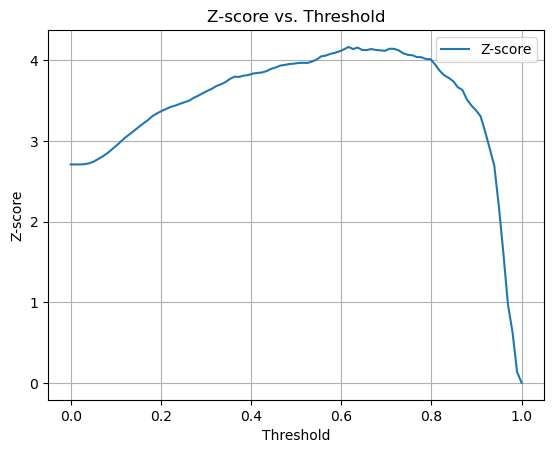

In [8]:
# Assume w_test is the array of weights for each sample in the test set
wn_test_array = np.array(wn_test*200000)

# Define thresholds between 0 and 1
thresholds = np.linspace(0, 1, 100)
z_scores = []

# Calculate the Z-score for each threshold using weights
for threshold in thresholds:
    # Weighted count of signal predictions above the threshold
    S = np.sum(wn_test_array[(all_outputs > threshold) & (all_labels == 1)])  # Weighted Signal
    B = np.sum(wn_test_array[(all_outputs > threshold) & (all_labels == 0)])  # Weighted Background

    # Calculate Z-score (add small epsilon to avoid division by zero)
    if S + B > 0:
        Z = S / np.sqrt(S + B + 1e-10)  # 1e-10 to avoid division by zero
    else:
        Z = 0  # Define Z as 0 if S + B is 0

    z_scores.append(Z)

# Plot Z-score vs. Threshold
plt.plot(thresholds, z_scores, label="Z-score")
plt.xlabel("Threshold")
plt.ylabel("Z-score")
plt.title("Z-score vs. Threshold")
plt.legend()
plt.grid()
plt.show()
